# SpecAugment with TorchAudio

### Prerequisites
Be sure you've run `install.sh` before running this notebook!

### Settings

In [4]:
#Export
from pathlib import Path
from fastai.vision import Image
from IPython.display import Audio
import mimetypes
import torchaudio
import matplotlib.pyplot as plt
import torch
from torchaudio import transforms

In [5]:
AUDIO_EXTENSIONS = tuple(str.lower(k) for k,v in mimetypes.types_map.items() 
                         if v.startswith('audio/'))

In [12]:
from fastai.basics import url2name, datapath4file, untar_data
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
path = datapath4file(url2name(data_url))
untar_data(data_url, dest = path) 
sample = path.ls()[256] # pick a file, any file!

Let's check out our sample wav file (a snippet of Bach).

In [13]:
def load_audio(p):
    return torchaudio.load(p)

In [14]:
def check_audio(p):
    sig,sr = load_audio(p)
    display(Audio(data=sig, rate=sr))
check_audio(sample)

We'll use a simple AudioData class as our atomic unit for audio.

In [15]:
class AudioData:
    '''Holds basic information from audio signal'''
    def __init__(self, sig, sr=16000): 
        self.sig = sig.reshape(-1) # We want single dimension data
        self.sr = sr

    @classmethod
    def load(cls, fileName, **kwargs):
        p = Path(fileName)
        if p.exists() & str(p).lower().endswith(AUDIO_EXTENSIONS):
            signal,samplerate = torchaudio.load(str(fileName))
            return AudioData(signal,samplerate)
        raise Exception(f"Error while processing {fileName}: file not found or does not have valid extension: {AUDIO_EXTENSIONS}")

In [16]:
audio = AudioData.load(sample)

## Wav to (Mel)Spectrogram

We'll use an undocumented SPEC2DB class from torchaudio to make a Melspectrogram.

In [17]:
from torch.autograd import Variable

def _check_is_variable(tensor):
    if isinstance(tensor, torch.Tensor):
        is_variable = False
        tensor = Variable(tensor, requires_grad=False)
    elif isinstance(tensor, Variable):
        is_variable = True
    else:
        raise TypeError("tensor should be a Variable or Tensor, but is {}".format(type(tensor)))

    return tensor, is_variable

class SPEC2DB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.

    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is -80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        self.top_db = -top_db if top_db > 0 else top_db
        self.multiplier = 10. if stype == "power" else 20.

    def __call__(self, spec):

        spec, is_variable = _check_is_variable(spec)
        spec_db = self.multiplier * torch.log10(spec / spec.max())  # power -> dB
        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new([self.top_db]))
        return spec_db if is_variable else spec_db.data

In [18]:
def tfm_spectro(ad:AudioData, sr=16000, to_db_scale=False, n_fft=400, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128, **kwargs):
    # We must reshape signal for torchaudio to generate the spectrogram.
    # Note we don't pass **kwargs to stop interference from other params in the tfms.
    mel = transforms.MelSpectrogram(sr=ad.sr, n_mels=n_mels, n_fft=n_fft, ws=ws, hop=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(ad.sig.reshape(1, -1))
    mel = mel.permute(0,2,1) # swap dimension...
    if to_db_scale: mel = SPEC2DB(stype='magnitude', top_db=f_max)(mel)
    return mel

In [19]:
def tensor_to_img(spectrogram):
    img = Image(spectrogram)
    display(img, img.shape)

In [20]:
spectro = tfm_spectro(audio, ws=50, hop=25, n_mels=256, to_db_scale=True)

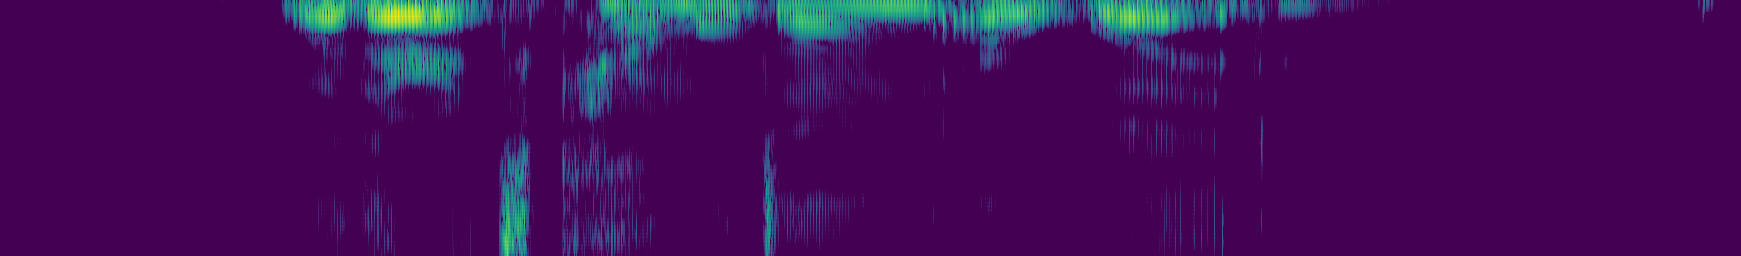

torch.Size([1, 256, 1741])

In [21]:
tensor_to_img(spectro)

## Time Warp

Time warp is described as:
>Time warping is applied via the function
sparse image warp of tensorflow. Given
a log mel spectrogram with τ time steps, we view it
as an image where the time axis is horizontal and the
frequency axis is vertical. A random point along the
horizontal line passing through the center of the image
within the time steps (W, τ − W) is to be warped
either to the left or right by a distance w chosen from a
uniform distribution from 0 to the time warp parameter
W along that line.

In [65]:
import random

In [83]:
line = spectro[0][256//2]
line[random.randrange(80, spectro.shape[2] - 80)]

tensor(-80.)

In [105]:
def time_warp(spec, W=80):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    
    horizontal_line_at_ctr = spec[0][num_rows//2]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]     
    assert isinstance(point_to_warp, torch.Tensor)

    # TODO: PYTORCH SPARSE_IMAGE_WARP HERE
    return spec


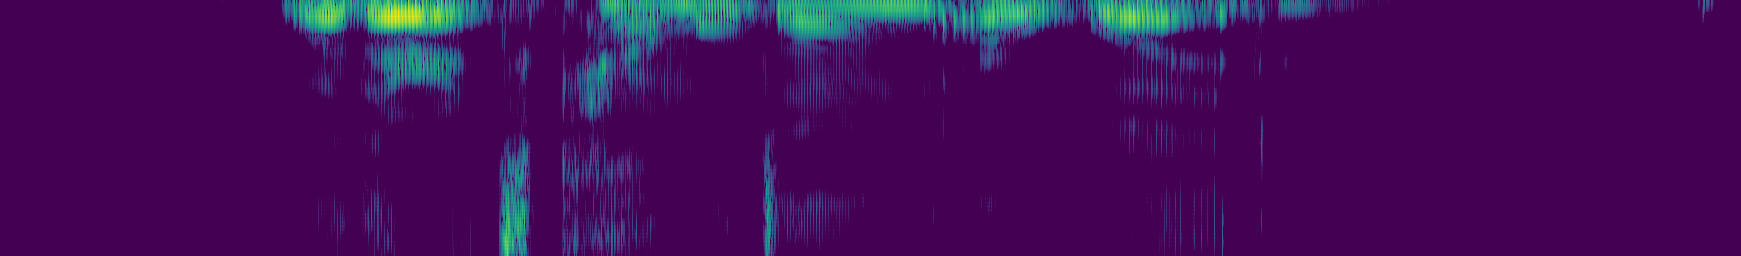

torch.Size([1, 256, 1741])

In [108]:
def test_time_warp():
    tensor_to_img(time_warp(spectro))
    
test_time_warp()

## Frequency Mask

Frequency masking is described as:
> Frequency masking is applied so that f consecutive mel
frequency channels [f0, f0 + f) are masked, where f is
first chosen from a uniform distribution from 0 to the
frequency mask parameter F, and f0 is chosen from 0, ν − f). ν is the number of mel frequency channels.

In [254]:
def freq_mask(spec, F=27, num_masks=1):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - F)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        cloned[0][f_zero:mask_end] = 0
    
    return cloned

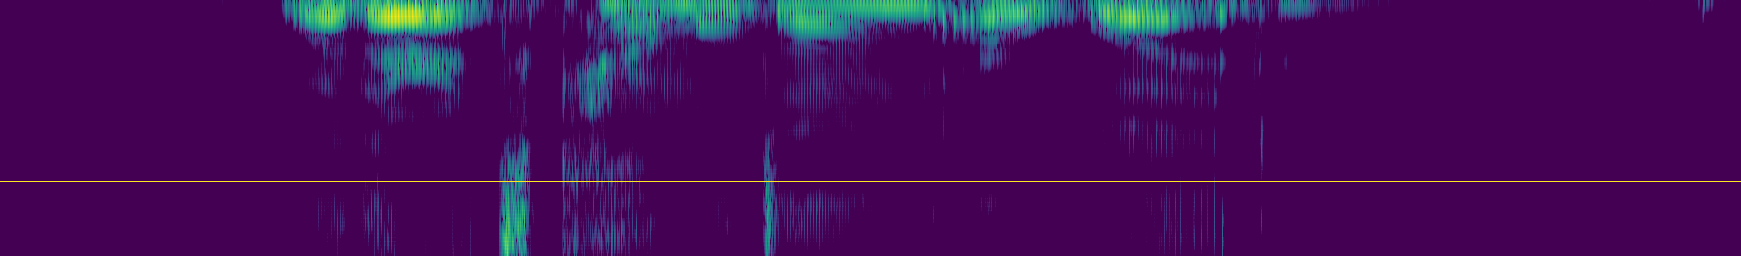

torch.Size([1, 256, 1741])

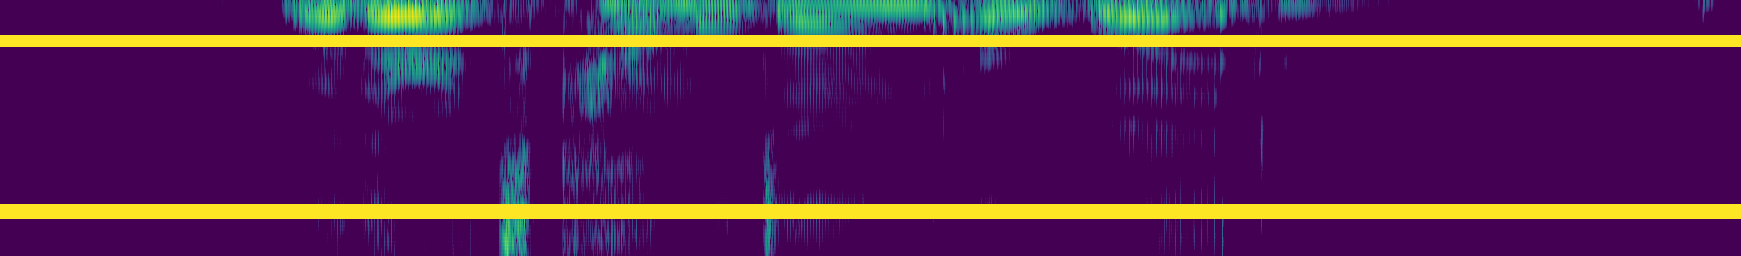

torch.Size([1, 256, 1741])

In [255]:
def test_freq_mask():
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
test_freq_mask()

## Time Mask

Time masking is described as:
> Time masking is applied so that t consecutive time steps
[t0, t0 + t) are masked, where t is first chosen from a
uniform distribution from 0 to the time mask parameter
T, and t0 is chosen from [0, τ − t).
• We introduce an upper bound on the time mask so
that a time mask cannot be wider than p times the
number of time steps.

In [256]:
def time_mask(spec):
    return spec

## Combined

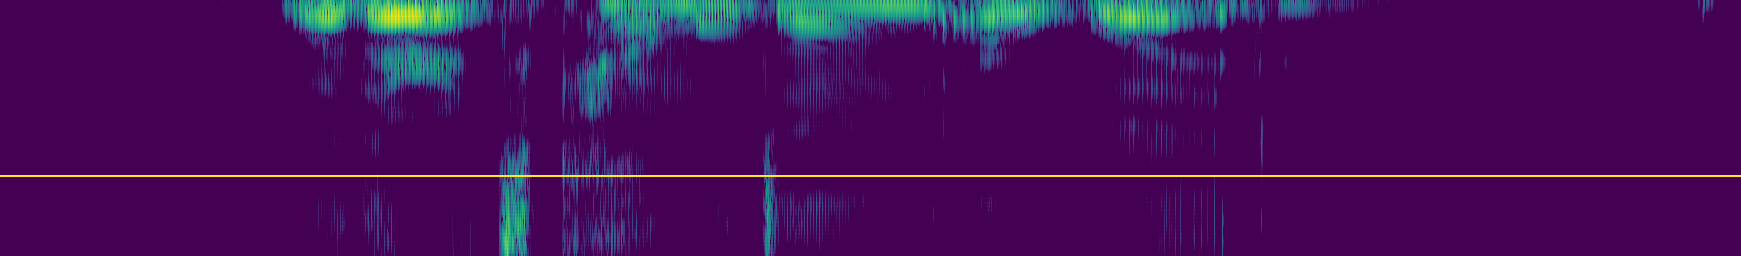

torch.Size([1, 256, 1741])

In [257]:
augmented = time_mask(freq_mask(time_warp(spectro)))
tensor_to_img(augmented)

## Performance

In [263]:
%%timeit
time_warp(spectro)

5.82 µs ± 356 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [262]:
%%timeit
freq_mask(spectro)

66.3 µs ± 1.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%timeit
time_mask(spectro)